# OPTRAM

In [34]:
import pandas as pd
import utm 
import folium
import geopandas as gpd
import matplotlib.pyplot as plt

## REGION OF STUDY


In [ ]:
def utm_to_latlon(coords, zone_number, zone_letter):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

In [52]:
# Arizona
utm_N = 12 
utm_Z = 'N'

In [55]:
# Test
utm_to_latlon(coords = [589567, 3512290], zone_number = utm_N, zone_letter = utm_Z)

(31.742561324317492, -110.05440485466326)

In [21]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


In [95]:
x,y = swrc.geometry[0].exterior.coords.xy

In [98]:
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    print(utm_to_latlon(coords = [x[i], y[i]], zone_number = utm_N, zone_letter = utm_Z))

(31.77196086872937, -109.88249882591717)
(31.771915755087036, -109.88249805041501)
(31.771861678933455, -109.88250398269578)
(31.771816663718987, -109.88251442499413)
(31.771771607970457, -109.88252024775349)
(31.771717507750637, -109.88252354029152)
(31.77166340843223, -109.88252683281388)
(31.771618236884194, -109.88251945798093)
(31.771579580101786, -109.882504421685)
(31.771529007977122, -109.88250605084411)
(31.771378568603485, -109.88238803106172)
(31.77137348034642, -109.88238512910839)
(31.77132808292704, -109.88235201605998)
(31.771290793602038, -109.88231927969127)
(31.77107799476143, -109.88215223183894)
(31.77107370433655, -109.88214916402528)
(31.771028387960893, -109.88212529123344)
(31.77097408012702, -109.88210482658371)
(31.770919766488166, -109.88208370097468)
(31.770874461686084, -109.88206114810455)
(31.77082913279789, -109.88203595450763)
(31.77078383957346, -109.8820147215326)
(31.770738494199637, -109.88198754819548)
(31.770693143036464, -109.88195971601544)
(31.

(31.712875504652434, -109.93799409820296)
(31.71289395162246, -109.93804269758552)
(31.712912569770108, -109.93811174233248)
(31.71293111097941, -109.93817155371987)
(31.712940565572936, -109.9382235525489)
(31.712968187814113, -109.93829051598497)
(31.712972167300975, -109.93832021025699)
(31.712995169380928, -109.93837274177807)
(31.7130340985348, -109.93849890166749)
(31.713051393877407, -109.93853229626771)
(31.71306984703904, -109.93858155537222)
(31.71308836606937, -109.938638728844)
(31.713089596384236, -109.93864217003186)
(31.71309676893702, -109.93865652757)
(31.713229956680994, -109.93894193300179)
(31.713244444924573, -109.93896476613996)
(31.713262903411312, -109.93901468496635)
(31.713290393524705, -109.93906582014718)
(31.713317922026384, -109.93912157101798)
(31.713336407892402, -109.93917478757028)
(31.71335486629863, -109.9392247064895)
(31.713373324685687, -109.93927462542898)
(31.713382827326768, -109.93933256147506)
(31.71340130212391, -109.93938445799067)
(31.7134

(31.678685435299172, -109.99386196391211)
(31.678622320379002, -109.99386660072216)
(31.67855917426708, -109.99386728280211)
(31.678514069895076, -109.99386776924729)
(31.678459960256106, -109.99387033192157)
(31.678414906987726, -109.99387741238027)
(31.678369859812, -109.99388515106185)
(31.6783247814454, -109.99388893502262)
(31.67827066659604, -109.99389083732724)
(31.678225609027113, -109.99389725845548)
(31.678180561848354, -109.9939049971092)
(31.678169656462003, -109.99390751052903)
(31.678027664538515, -109.99396467078192)
(31.677921984393116, -109.99402259342908)
(31.677883954433796, -109.9940453443096)
(31.677839051904673, -109.99407154302226)
(31.677794145081172, -109.99409708346349)
(31.677740227764026, -109.99412403866717)
(31.677695341721343, -109.99415221621582)
(31.67765045046513, -109.99417973339216)
(31.677605595596155, -109.99421186662347)
(31.67756068353406, -109.9942367465867)
(31.677515781869992, -109.99426294615827)
(31.677470843808585, -109.9942845296288)
(31.6

(31.678516876187835, -110.05445803917848)
(31.678315006040222, -110.05457863738027)
(31.678302068442697, -110.05458843622824)
(31.678257178241992, -110.05461790383549)
(31.67821544265792, -110.05464222179587)
(31.678078244421542, -110.05474186849713)
(31.678073885453113, -110.0547449562418)
(31.678041028225035, -110.05476880224465)
(31.678033740768065, -110.05477249355913)
(31.677978933035824, -110.05481061829599)
(31.677934033000245, -110.05483876602894)
(31.677880053303337, -110.05485909348191)
(31.67783508976518, -110.0548786712749)
(31.677781080753945, -110.05489504286537)
(31.677771334912094, -110.05489813030505)
(31.677736078134473, -110.05490934619966)
(31.677691026662533, -110.05491705544357)
(31.677636978578573, -110.05492815362541)
(31.677591936872773, -110.05493718145364)
(31.67754684144843, -110.05493895801531)
(31.677501697174584, -110.05493414051197)
(31.677447492794478, -110.0549241410457)
(31.67743488757664, -110.05492206070404)
(31.677285932542983, -110.05491631464692)

(31.698690866319662, -110.10709654808002)
(31.69872666460683, -110.1070553158924)
(31.6987624905865, -110.10701804043752)
(31.698789272322795, -110.10697755406989)
(31.698825038241885, -110.10693170556483)
(31.69886976524504, -110.10687719759541)
(31.6989054803198, -110.10682409493344)
(31.698932196430793, -110.10677437704567)
(31.698967851409552, -110.10671270130136)
(31.69898548256183, -110.10665383732078)
(31.699012051659587, -110.10658301548096)
(31.69902969199158, -110.10652547037434)
(31.699047273121867, -110.10648304276823)
(31.69906214734914, -110.10641712993119)
(31.69906487462633, -110.10639653033274)
(31.699068252241762, -110.10639007488291)
(31.69909900943676, -110.10625377802377)
(31.699179312251335, -110.10612638259346)
(31.699196614898057, -110.10602069540062)
(31.69920625980893, -110.10597394666704)
(31.699205994024307, -110.10593616415434)
(31.699224549653394, -110.10588529374931)
(31.699248966255606, -110.10576694213896)
(31.699319877424948, -110.10558687549063)
(31.6

(31.744007520470557, -110.12406134116023)
(31.74399813107848, -110.12400798462734)
(31.74397063228826, -110.12394490119355)
(31.74396111673339, -110.12387307073874)
(31.743960722064525, -110.12381567060132)
(31.743960308319867, -110.12375563133828)
(31.743959904523578, -110.12369691163558)
(31.74397747940374, -110.12362878398731)
(31.743977093700508, -110.12357270341134)
(31.743984716673495, -110.12352372526104)
(31.743984374318735, -110.1234739532723)
(31.74401561572083, -110.12336892599106)
(31.7440205645383, -110.12333475945591)
(31.744038188262156, -110.12327389039051)
(31.744055220664734, -110.12323578193744)
(31.744072551934252, -110.12317752005713)
(31.744134900664985, -110.12306080288518)
(31.744142632896057, -110.12304791668949)
(31.744144861730636, -110.12304326633299)
(31.744158771671177, -110.12302102203581)
(31.744224094653404, -110.12291216077402)
(31.744394551179536, -110.12277330956901)
(31.74453801687971, -110.12264526962674)
(31.7446069006932, -110.12259252728137)
(31

(31.76135456372085, -109.992115657238)
(31.76136306235128, -109.99204957124259)
(31.76137157660399, -109.99198546382699)
(31.761380164843043, -109.99193059579888)
(31.76138870515538, -109.99186978882985)
(31.76139728721111, -109.99181425985388)
(31.761396791047506, -109.99175157102613)
(31.761405347845603, -109.99169274366969)
(31.761404893410514, -109.99163533389823)
(31.76142240730838, -109.991568489065)
(31.76143989073552, -109.99149768595767)
(31.76144843605569, -109.99143753774241)
(31.76146590805709, -109.99136541483674)
(31.761492547968274, -109.991311669709)
(31.761519124239207, -109.991250004907)
(31.761545716165408, -109.9911903207762)
(31.76157229328635, -109.9911286569515)
(31.761589874866438, -109.99107039145203)
(31.761616519876153, -109.99101730605443)
(31.76164320577723, -109.99096949970844)
(31.761669828932128, -109.99091377472543)
(31.76168743131363, -109.99085814760771)
(31.761696055655772, -109.99080789849229)
(31.761713678902826, -109.99075491087777)
(31.7617222709

<AxesSubplot:>

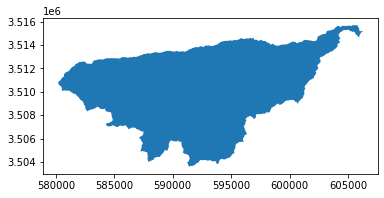

In [99]:
swrc.plot()

In [27]:
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')
for _, r in swrc.iterrows():
    # Without simplifying the representation of each borough,
    # the map might not be displayed
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    print(geo_j)
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {}, "geometry": {"type": "Polygon", "coordinates": [[[605817.3799999999, 3515703.1279000007], [605817.5048000002, 3515698.1279000007], [605817.0045999996, 3515692.1279000007], [605816.0669999998, 3515687.1279000007], [605815.5669, 3515682.1279000007], [605815.0664999997, 3515670.127800001], [605815.8163000001, 3515665.127800001], [605817.2841999996, 3515660.8574], [605817.1875, 3515655.25], [605828.5349000003, 3515638.6888999995], [605828.8154999996, 3515638.127699999], [605832.0028999997, 3515633.127699999], [605835.1453999998, 3515629.0261000004], [605851.2067, 3515605.600299999], [605851.5021000002, 3515605.127699999], [605853.8143999996, 3515600.127699999], [605855.8141999999, 3515594.127699999], [605857.8766000001, 3515588.127699999], [605860.0639000004, 3515583.127699999], [605862.5012999997, 3515578.1275999993], [605864.5636, 3515573.1275999993], [605867.1885000002, 3515568.1275999993], [6058

## LOAD DATA

In [3]:
names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
l1tdr17 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l1tdr17.out',
                  sep='\s+', 
                  names = names)

In [4]:
l1tdr17["datetime"] = (
                        pd.to_datetime(l1tdr17['year'] * 1000 + l1tdr17['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l1tdr17["hr"], unit="h") 
                        +
                        pd.to_timedelta(l1tdr17["mn"], unit="min") 
                      )

In [5]:
l1tdr17.set_index('datetime', inplace = True)

In [6]:
l1tdr17

,site,year,day,hr,mn,SM5,SM15,SM30,SM50,SM75,SM100,SM200
datetime,,,,,,,,,,,,
2017-01-01 00:30:00,3008,2017,1,0,30,11,8,6,6,15,12,14
2017-01-01 01:00:00,3008,2017,1,1,0,11,9,6,6,14,12,14
2017-01-01 01:30:00,3008,2017,1,1,30,11,8,6,6999,15,13,14
2017-01-01 02:00:00,3008,2017,1,2,0,11,8,6,6,15,12,14
2017-01-01 02:30:00,3008,2017,1,2,30,12,7,6,6,14,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 22:00:00,3008,2017,365,22,0,5,6,6,5,11,12,14
2017-12-31 22:30:00,3008,2017,365,22,30,5,6,7,6,11,12,14
2017-12-31 23:00:00,3008,2017,365,23,0,5,6,5,6,12,12,14


<AxesSubplot:xlabel='datetime'>

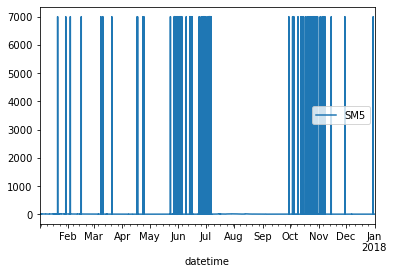

In [39]:
l1tdr17.plot(y='SM5', use_index=True)

In [43]:
l1tdr17_fix = l1tdr17.replace(6999, None)

<AxesSubplot:xlabel='datetime'>

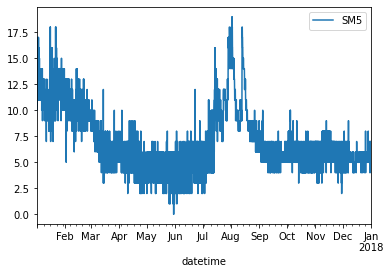

In [44]:
l1tdr17_fix.plot(y='SM5', use_index=True)